In [2]:
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
params = {
    'legend.fontsize': 12,
    'legend.handlelength': 2,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
}
plt.rcParams.update(params)
from multiprocessing import Pool
from pathlib import Path
from astropy import units as u
from astropy.table import Table
from astropy.io import fits

In [3]:
import itertools
import deflector_load
def generate_source_data(granularity): # (simulated for now)
    z_single = np.linspace(5.3, 6.9, granularity)
    # sep = np.linspace(0.03, 5, granularity) # 0.03 is the minimum resolution by JWST
    sep_single = np.linspace(0.1, 10, granularity) # 0.1 is the minimum object separation of the dataset
    props = np.array([x for x in itertools.product(z_single, sep_single)]).T
    z_all = props[0]
    sep_all = props[1] * u.arcsec
    return Table([z_all, sep_all], names=['z', 'sep'])


granularity = 100
simulated_sources = generate_source_data(granularity)
simulated_deflectors = deflector_load.load_simulated_from_path("../Data/JAGUAR/concatenated_unfiltered.fits", show_plots=False)

Keeping 802/605030 galaxies from concatenated_unfiltered.fits


In [4]:
import compute_magnifications
mag_pre = compute_magnifications.compute_magnifications(simulated_sources, simulated_deflectors)
# in this form, magnifications has a shape of (m_source, n_deflector)
mag_2d = compute_magnifications.normalize_magnifications(mag_pre)
mag_3d = compute_magnifications.inflate_magnifications(mag_2d)
phase_space_3d = (
    np.unique(simulated_sources['sep']),
    np.unique(simulated_sources['z']),
    simulated_deflectors['z']
)

Initial mu values: max 562261.49, min -5484204.452874911, mean 0.33, std 1992.27
Correcting negative lensing for 673289 pairs (8.3951 %)
Correcting strong lensing for 50464 pairs (0.6292 %)
Final mu values: max 15.00, min 0.01592822302257819, mean 1.66, std 1.96


In [5]:
from matplotlib.colors import LogNorm

def show_magnifications(
        mag: np.ndarray,
        phase_space_range,
        phase_space_labels,
        title: str
    ):

    f = plt.figure()
    plt.tight_layout()
    ax = f.add_axes([0.17, 0.1, 0.72, 0.79])
    axcolor = f.add_axes([0.90, 0.1, 0.03, 0.79])
    # sizes of elements in the plot

    ax.set_ylabel(phase_space_labels[0])
    ax.set_xlabel(phase_space_labels[1])
    # rows and cols are swapped

    extent = [ # first x range then y range
        phase_space_range[1][0], phase_space_range[1][-1],
        phase_space_range[0][0], phase_space_range[0][-1]
    ]
    im = ax.imshow(
        mag,
        norm=LogNorm(vmin=1, vmax=np.max(mag)),
        extent=extent,
        aspect='auto'
    )
    ticks = np.linspace(1, int(np.max(mag)), num=4, dtype=int) #[1, 2, 4, 8, 15]
    f.colorbar(im, cax=axcolor, ticks=ticks, format="%.1f")
    ax.set_title(title)


(100, 100, 802)
(100, 802)
(100, 802)
(100, 100)


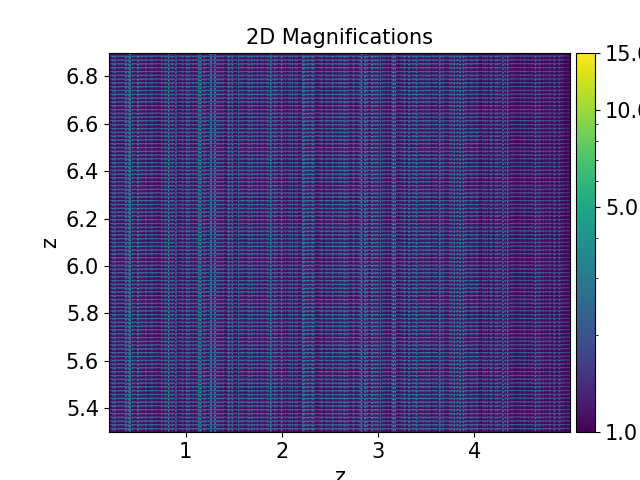

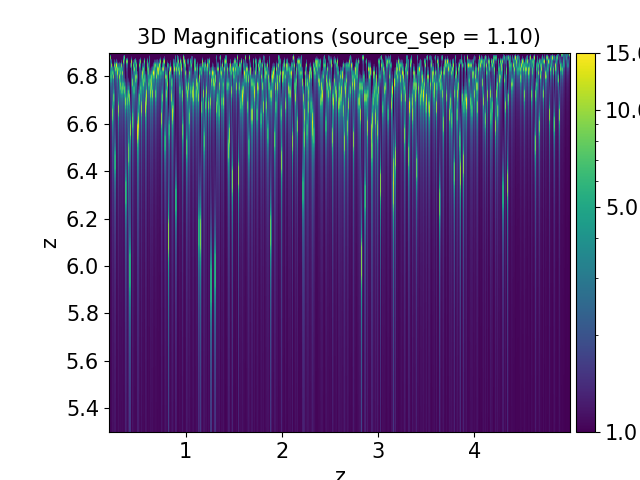

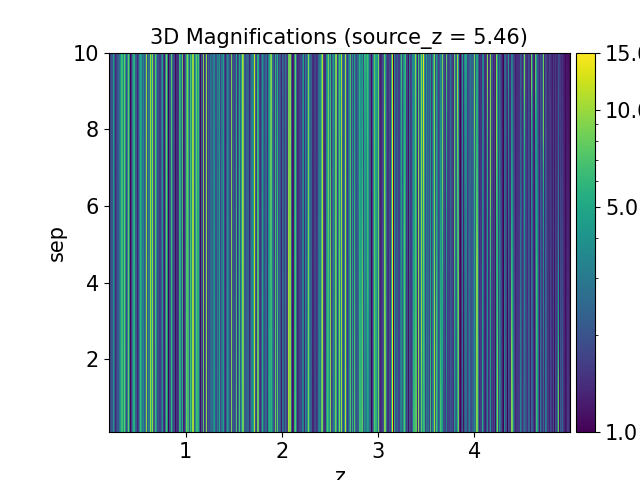

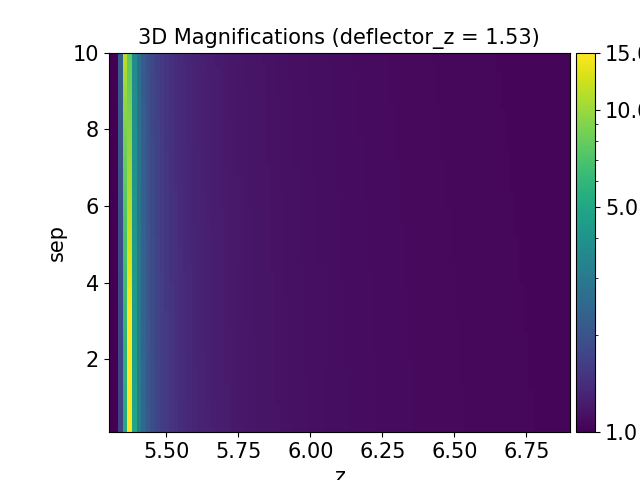

In [6]:
show_magnifications(
    mag_2d,
    (simulated_sources["z"].value, simulated_deflectors["z"].value),
    (simulated_sources["z"].name, simulated_deflectors["z"].name),
    "2D Magnifications"
    )
# not very interesting


print(mag_3d.shape)
# mag_3d has axis:
# 0 : source_separation (increasing)
# 1 : source_redshift (increasing)
# 2 : deflector (not sorted by redshift or mass) (but could be!)
# source_sep = phase_space_3d[0]
# source_z = phase_space_3d[1]
# deflector_z = phase_space_3d[2]

# TODO compute 2D array for fixed z_source and plot using imshow
show_magnifications(
    mag_3d[10,:,:],
    (phase_space_3d[1].value, phase_space_3d[2].value),
    (phase_space_3d[1].name, phase_space_3d[2].name),
    f"3D Magnifications (source_sep = {phase_space_3d[0][10]:.2f})"
    )
print(mag_3d[10,:,:].shape)

show_magnifications(
    mag_3d[:,10,:],
    (phase_space_3d[0].value, phase_space_3d[2].value),
    (phase_space_3d[0].name, phase_space_3d[2].name),
    f"3D Magnifications (source_z = {phase_space_3d[1][10]:.2f})"
    )
print(mag_3d[:,10,:].shape)

show_magnifications(
    mag_3d[:,:,500],
    (phase_space_3d[0].value, phase_space_3d[1].value),
    (phase_space_3d[0].name, phase_space_3d[1].name),
    f"3D Magnifications (deflector_z = {phase_space_3d[2][500]:.2f})"
    )
print(mag_3d[:,:,500].shape)


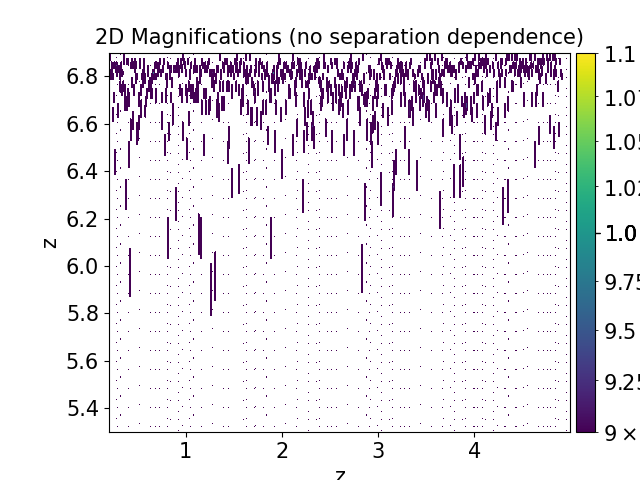

In [7]:
# last plot is interesting
# drop separation dependence
mag_2d_no_sep = np.mean(mag_3d, axis=0)
show_magnifications(
    mag_2d_no_sep > 10,
    (phase_space_3d[1].value, phase_space_3d[2].value),
    (phase_space_3d[1].name, phase_space_3d[2].name),
    "2D Magnifications (no separation dependence)"
    )
    

## Verify how $\mu$ depends on the 4 parameters:
It is not quantitatively clear how the parameters affect the likelihood of high ($\geq 2$) $\mu$.

To further investigate this we visualize relationships between $\mu$ and $z_{deflector}$, $\sigma_{deflector}$

In [8]:
# def multiplot_magnification_hists(magnifications):
#     # plot 2x2 grid of magnification histograms
#     fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
#     fig.suptitle("Magnification for different source configurations")
    
#     ax1, ax2, ax3, ax4 = axs.flat
#     print(magnifications.shape)
#     # magnifications already sorted by source redshift in
    
#     # plot 1: magnifications wrt z_deflector (also showing zsource as color)

#     magnifications_mean_by_z = np.vstack([np.mean(magnifications[i:i+granularity, ...], axis=0) for i in range(granularity)])
#     z_source = np.unique(simulated_sources["z"].data)
#     # sparsen by factor 2
#     # magnifications_mean_by_z = np.vstack([np.mean(magnifications_mean_by_z[i:i+1,...], axis=0) for i in range(0, magnifications_mean_by_z.shape[0], 2)])
#     # z_source = z_source[::2]
#     z_deflector_sort = np.argsort(simulated_deflectors["z"])
#     magnifications_sorted = magnifications_mean_by_z[..., z_deflector_sort]
#     z_deflector_sorted = simulated_deflectors["z"][z_deflector_sort]
#     # sparsen up the data
#     # magnifications_sorted = magnifications_sorted[...,::10]
#     # z_deflector_sorted = z_deflector_sorted[::10]
#     crepeat = z_deflector_sorted.size
#     # flatten
#     magnifications_sorted = magnifications_sorted.T.flatten()
#     z_deflector_sorted = np.repeat(z_deflector_sorted, magnifications_mean_by_z.shape[0])
#     colors = np.vstack([z_source for i in range(crepeat)]).flatten()
#     print(magnifications_sorted.shape, z_deflector_sorted.shape, colors.shape)
#     print(colors)
#     ax1.scatter(z_deflector_sorted, magnifications_sorted, c=colors, cmap="coolwarm", alpha=0.1)


def multiplot_magnification_hists(magnifications):
    # plot 2x2 grid of magnification histograms
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.suptitle("Magnification for different source configurations")
    
    ax1, ax2, ax3, ax4 = axs.flat
    # magnifications already sorted by source redshift in
    
    # plot 1: hist of deflectors where magnification > 2 with bins in the z_deflector range
    # (also showing zsource as color)
    step = 1
    mag_subsets = [magnifications[i:i+granularity * step, ...] for i in range(0, granularity, step)]
    magnifications_mean_by_z = np.vstack([np.mean(s, axis=0) for s in mag_subsets])
    magnifications_std_by_z = np.vstack([np.std(s, axis=0) for s in mag_subsets])
    
    z_deflector_sort = np.argsort(simulated_deflectors["z"])
    magnifications_sorted = magnifications_mean_by_z[..., z_deflector_sort]
    z_deflector_sorted = simulated_deflectors["z"][z_deflector_sort]
    # sparsen up the data
    magnifications_sorted = magnifications_sorted[...,::10]
    magnifications_std_by_z = magnifications_std_by_z[...,::10]
    z_deflector_sorted = z_deflector_sorted[::10]
    # flatten
    magnifications_sorted = magnifications_sorted.T.flatten()
    errors_sorted = magnifications_std_by_z.T.flatten()
    z_deflector_sorted = np.repeat(z_deflector_sorted, magnifications_mean_by_z.shape[0])
    ax1.errorbar(z_deflector_sorted, magnifications_sorted, yerr=errors_sorted, fmt="o")

    # plot 1: hist of deflectors where magnification > 2 with bins in the z_deflector range
    # (also showing zsource as color)
    z_deflector_sort = np.argsort(simulated_deflectors["z"])
    magnifications_sorted = magnifications_mean_by_z[..., z_deflector_sort]
    z_deflector_sorted = simulated_deflectors["z"][z_deflector_sort]

    # z_source = np.unique(simulated_sources["z"])
    z_source = simulated_sources["z"]
    mag_z_only = np.vstack([np.mean(magnifications_sorted[i: i + granularity, ...], axis=0) for i in range(granularity)])
    ax2.imshow(np.diff(magnifications, axis=0))

    # average out the mags_by_z)#, c=z_source, cmap="heat")

# multiplot_magnification_hists(mag_3d)

In [9]:
plt.close("all")

## Apply filtering of magnitudes and export to catalog

In [10]:
import deflector_filter
import source_load
import cross_correlate


SEP = [
    [0.1, 4],
    [0.1, 5],
    [0.1, 6],
    [0.1, 7],
] # must have step 1 for matplotlib sliders
MIN_MU = [2, 3, 4, 5]
MU_THRESH = [0.2, 0.3, 0.4, 0.5]
DEFLECTOR_SELECTION_METHODS = ["minmax", "normal"]

FULL_PARAMS = list(itertools.product(SEP, MIN_MU, MU_THRESH, DEFLECTOR_SELECTION_METHODS))


SCIENCE_TARGET = "J0100"
SCIENCE_TARGET_FULL_DATA = Path(f"../Data/{SCIENCE_TARGET}_photcat_v4_noisemodel_short.fits")
SCIENCE_TARGET_SOURCE_DATA = Path(f"../Data/{SCIENCE_TARGET}_O3_emitters.fits")
SCIENCE_REFERENCE_IMAGE = Path(f"../Data/{SCIENCE_TARGET}_full_R_only.fits")

RANDOMS_PATH = Path("../Data/rand_cat_v2_fastsingle_200000.fits")


In [11]:
actual_sources = source_load.load_sources(source_catalog_path = SCIENCE_TARGET_SOURCE_DATA, source_frame_path=SCIENCE_REFERENCE_IMAGE)

def get_bins(
    # required parameters for computations
    angular_separation_range, minimum_mu, minimum_mu_threshold, deflector_selection_method,
    # optional parameters for plotting
    bin_method: str = "log",
    plot_method: str = "lin",
    ):
    PARAMETER_DATA_DIR = Path(f"../Cache/{SCIENCE_TARGET}__angular_separation_{angular_separation_range[0]}_{angular_separation_range[1]}__min_mu_{minimum_mu}__mu_thresh_{minimum_mu_threshold}")
    PARAMETER_DATA_DIR.mkdir(exist_ok=True, parents=True)

    actual_deflectors = deflector_filter.load_or_compute_actual_deflectors(
        PARAMETER_DATA_DIR,
        SCIENCE_TARGET_FULL_DATA,
        mag_2d,
        simulated_deflectors,
        simulated_sources,
        angular_separation_range,
        minimum_mu,
        minimum_mu_threshold,
        deflector_selection_method,
        show_plots = "no",
        return_potential_deflectors = False
        )
    CCC = cross_correlate.CrossCorrelationCalculator(
        PARAMETER_DATA_DIR,
        actual_sources,
        source_frame_path = SCIENCE_REFERENCE_IMAGE,
        randoms_path = RANDOMS_PATH,
        deflector_selection_method= deflector_selection_method,
        binning_method = bin_method,
        nbins = 20,
        binning_max_pixels = 500, #roughly 8 arcsec
        show_plots = False
    )

    source_bins = CCC.match_with_o3_sources(actual_deflectors)

    random_bins, random_error = CCC.compute_random_separation_expectation(
        deflectors = actual_deflectors,
        n_draws = 1000
    )
    edges = CCC.bins_as_arcsec

    if plot_method == "log":
        source_bins[source_bins < 1] = 1
        random_bins[random_bins < 1] = 1
        random_error[random_error < 1] = 1
    return edges, source_bins, random_bins, random_error


def preload_bins():
    print(f"Computing bins for {len(FULL_PARAMS)} parameter combinations.")
    with Pool(6) as mp_pool:
        mp_pool.starmap(get_bins, FULL_PARAMS)
    print("Done.")
    # results = [get_bins(*p) for p in params] but parallelized


# preload_bins()

In [12]:
from matplotlib.widgets import Slider

def show_deflector_cross_correlation(bin_method, plot_method):

    angular_separation_range_initial = SEP[0]
    minimum_mu_initial = MIN_MU[0]
    minimum_mu_threshold_initial = MU_THRESH[0]

    # Create the figure and the line that we will manipulate
    fig, ax = plt.subplots()
    ax.set_xlabel('Separation [arcsec]')
    ax.set_ylabel('Number of matches')

    
    # adjust the main plot to make room for the sliders
    fig.subplots_adjust(bottom=0.4)

    sep_ax = fig.add_axes([0.2, 0, 0.6, 0.1]) # left bottom width height
    sep_high_range = [r[1] for r in SEP]
    sep_slider = Slider(
        ax=sep_ax,
        label='Max. separation [arcsec]',
        valmin=sep_high_range[0],
        valmax=sep_high_range[-1],
        valinit=sep_high_range[0],
        valstep=1,
    )
    mu_ax = fig.add_axes([0.2, 0.1, 0.6, 0.1]) # left bottom width height
    mu_slider = Slider(
        ax=mu_ax,
        label='Min. mu',
        valmin=MIN_MU[0],
        valmax=MIN_MU[-1],
        valinit=MIN_MU[0],
        valstep=1,
    )
    thresh_ax = fig.add_axes([0.2, 0.2, 0.6, 0.1]) # left bottom width height
    thresh_slider = Slider(
        ax=thresh_ax,
        label='Min. objects where mu > mu_thresh',
        valmin=MU_THRESH[0],
        valmax=MU_THRESH[-1],
        valinit=MU_THRESH[0],
        valstep=0.1,
    )

    current_data = get_bins(angular_separation_range_initial, minimum_mu_initial, minimum_mu_threshold_initial, bin_method, plot_method, "minmax")
    # for the interactive plot, many configurations need to be precomputed. We only did this for minmax
    x = current_data[0]
    x = x[:-1] + np.diff(x)/2

    source_visual, = ax.plot(x, current_data[1], "o", lw=2, label="O3 sources")
    err_low_visual, = ax.plot(x, current_data[2] - current_data[3], "-o", color="black", markersize=2)
    err_high_visual, = ax.plot(x, current_data[2] + current_data[3], "-o", color="black", markersize=2)
    err_between_visual = ax.fill_between(x.value, current_data[2] + current_data[3], current_data[2] - current_data[3], alpha=0.2, color="black", label="Uncertainty of matches with randomly scattered objects")

    # visual adjustments
    ax.set_ylim(1, 1.5 * np.max(current_data[1]))
    if plot_method == "log":
        ax.set_yscale("log")
    if bin_method == "log":
        ax.set_xscale("log")


    # The function to be called anytime a slider's value changes
    def update(val):
        current_data = get_bins([0.1, sep_slider.val], mu_slider.val, round(thresh_slider.val, 1))
        source_visual.set_ydata(current_data[1])
        err_low_visual.set_ydata(current_data[2] - current_data[3])
        err_high_visual.set_ydata(current_data[2] + current_data[3])
        
        ax.collections.pop()
        # fill_between creates a PolyCollection which can be removed
        err_between_visual = ax.fill_between(x.value, current_data[2] + current_data[3], current_data[2] - current_data[3], alpha=0.2, color="black", label="Uncertainty of matches with randomly scattered objects")
        ax.set_ylim(1, 1.5 * max(np.max(current_data[1]), 1))
        fig.canvas.draw_idle()


    # register the update function with each slider
    sep_slider.on_changed(update)
    mu_slider.on_changed(update)
    thresh_slider.on_changed(update)


    ax.legend()
    plt.show()

In [13]:
## Interactive plot
# show_deflector_cross_correlation(bin_method="lin", plot_method="lin")
# show_deflector_cross_correlation(bin_method="lin", plot_method="log")
# show_deflector_cross_correlation(bin_method="log", plot_method="log")

No cached data found, computing simulated deflectors...
Considering 4800/10000 source configurations for magnitude threshold.
Keeping 210 deflectors out of 802.
Applying filtering to full science catalog to obtain deflector selection
Method minmax generates 0 interlopers -> out of 210 only 210 are retained
Minmax method generates 610/18373 deflectors
minmax method generates 610/18373 deflectors


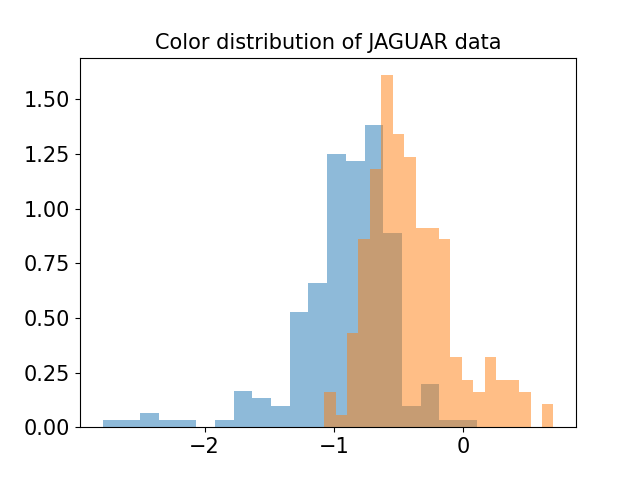

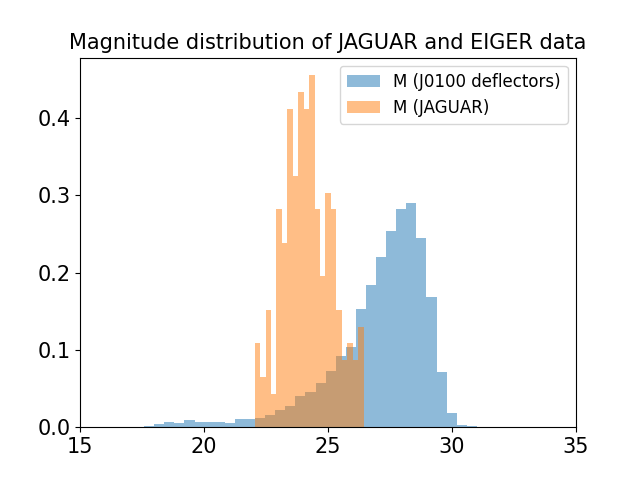

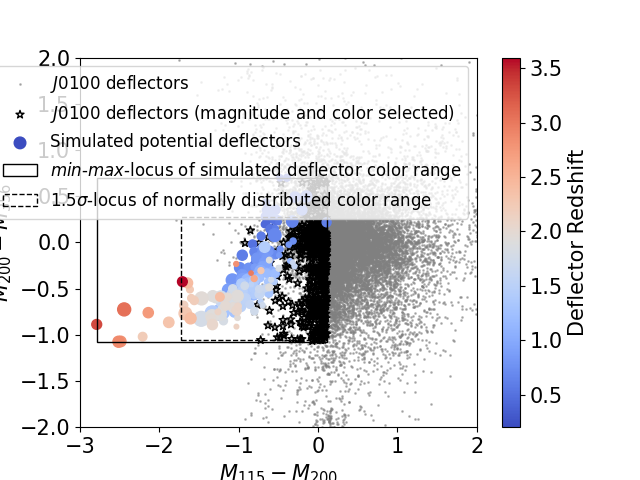

KS test for z-distribution: p=0.00 stats=0.7368421052631579


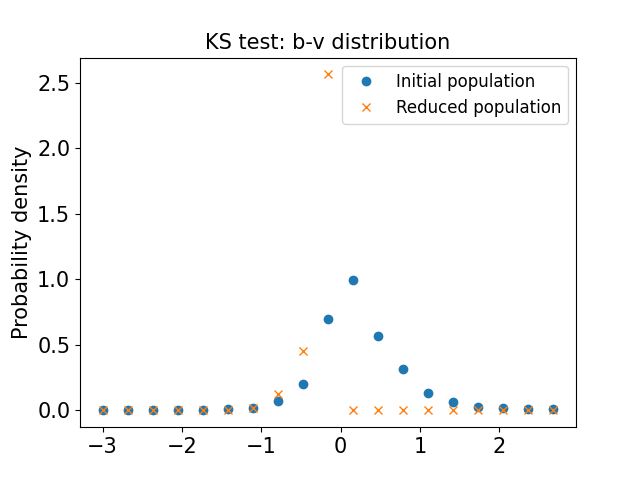

KS test for z-distribution: p=0.00 stats=0.631578947368421


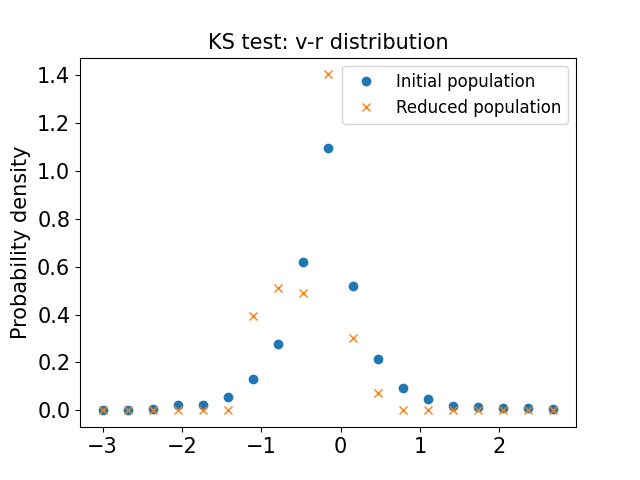

KS test for z-distribution: p=0.54 stats=0.2631578947368421


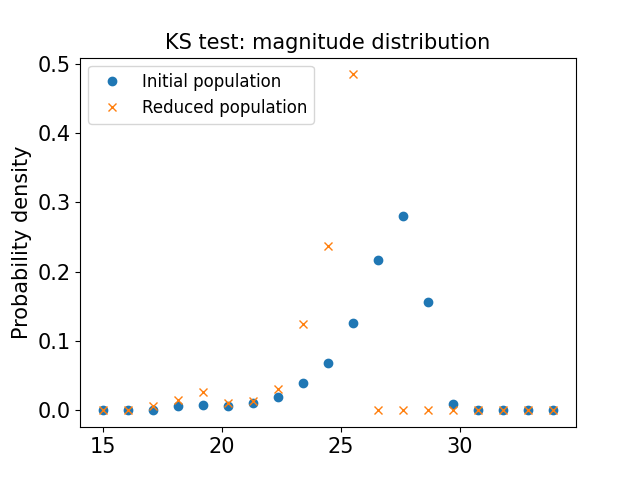

In [14]:
MAGIC_PARAMS = {
    "sep": [0.1, 5],
    "min_mu": 2,
    "mu_thresh": 0.3,
    # "deflector_selection_method": "normal"
    "deflector_selection_method": "minmax"
}

PARAMETER_DATA_DIR = Path(f"../Cache/{SCIENCE_TARGET}__angular_separation_{MAGIC_PARAMS['sep'][0]}_{MAGIC_PARAMS['sep'][1]}__min_mu_{MAGIC_PARAMS['min_mu']}__mu_thresh_{MAGIC_PARAMS['mu_thresh']}")

## Deflector selection for the chosen parameters
# also plots the visualizations available along the way
actual_deflectors, potential_deflectors = deflector_filter.load_or_compute_actual_deflectors(
    PARAMETER_DATA_DIR,
    SCIENCE_TARGET_FULL_DATA,
    mag_2d,
    simulated_deflectors,
    simulated_sources,
    MAGIC_PARAMS["sep"],
    MAGIC_PARAMS["min_mu"],
    MAGIC_PARAMS["mu_thresh"],
    MAGIC_PARAMS["deflector_selection_method"],
    show_plots = "actual",
    return_potential_deflectors = True
    )


ValueError: Number of world inputs (0) does not match expected (1)

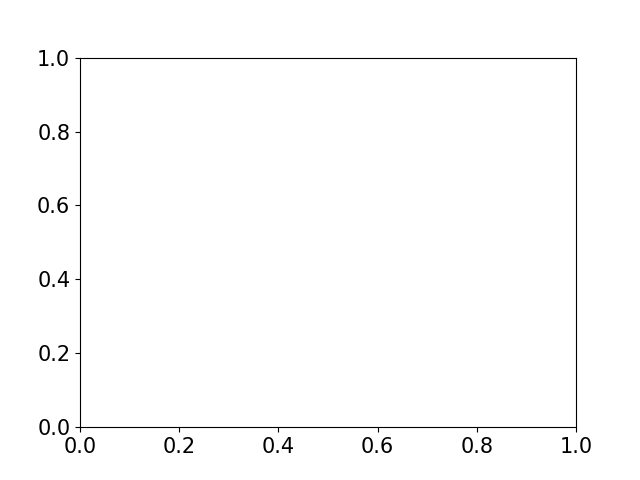

In [16]:
## Plot where the deflectors and the sources lie in the image
# actual_deflectors and actual_sources have been defined in previous cells
# 
from astropy.visualization import ImageNormalize, ZScaleInterval
from astropy.wcs import WCS


def add_scale(hdu, ax):
    from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
    wcs = WCS(hdu['SCI'].header)
    # compute the number of pixels one arcsecond corresponds to
    pix = 
    pix_1_arcsec = u.degree.to(u.arcsec) * wcs.pixel_scale_matrix[0][0]**-1
    # TODO: this is wrong!
    asb = AnchoredSizeBar(
        ax.transData,
        pix,
        r"1$^{\prime\prime}$",
        loc='lower center',
        pad=3, borderpad=3, sep=5,
        frameon=False
        )
    ax.add_artist(asb)

def plot_found_objects(deflectors, sources):
    hdu = fits.open(SCIENCE_REFERENCE_IMAGE)
    frame = hdu[0]
    plt.figure()
    ax = plt.gca()
    add_scale(hdu, ax)
    plt.scatter(deflectors["X_IMAGE_det"], deflectors["Y_IMAGE_det"], marker="o", color="none", edgecolor="blue", label="$J0100$ deflectors)")
    plt.scatter(sources["x"], sources["y"], marker="o", color="none", edgecolor="red", label="$J0100$ sources)")
    plt.imshow(frame.data, cmap='gray', origin='lower', norm = ImageNormalize(frame.data, interval=ZScaleInterval()))
    # plt.hlines(10, 10, 10 + pix_1_degree, colors=["red"])
    # hide the axes
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    # smaller padding
    plt.tight_layout()
    plt.legend()
    plt.show()

# print(actual_deflectors.colnames, actual_sources.colnames)
plot_found_objects(actual_deflectors, actual_sources)
print(f"{len(actual_deflectors)=}, {len(actual_sources)=}")

In [ ]:
## Plot single configuration in a clean way
clustering = get_bins(*(MAGIC_PARAMS.values()), bin_method="lin", plot_method="log")

plt.figure()
# plt.ylim(1, 1.5 * np.max(clustering_minmax[1]))
plt.yscale("log")
plt.xlabel('Separation [arcsec]')
plt.ylabel('Matches count')


x = clustering[0]
x = x[:-1] + np.diff(x)/2

plt.plot(x, clustering[1], "o", lw=2, label="Count of $EIGER$ deflector/source pairs as a function of separation (min/max)")
plt.plot(x, clustering[2] - clustering[3], "--o", color="blue", markersize=2)
plt.plot(x, clustering[2] + clustering[3], "--o", color="blue", markersize=2)
plt.fill_between(x.value, clustering[2] + clustering[3], clustering[2] - clustering[3], alpha=0.2, color="blue", label="Baseline count of deflector/simulated pairs with a $\pm 1\sigma$ confidence interval (min/max))")

# hightlight the points that are above the threshold
keep_indices = clustering[1] > clustering[2] + 3 * clustering[3]
keep_indices[0] = False # remove the first point, which is always above the baseline
x_above = x[keep_indices]
ymax = clustering[2][keep_indices] + clustering[3][keep_indices]
ymin = clustering[1][keep_indices]
plt.vlines(x_above, ymin, ymax, color="red", label="Separations where the deviation $\geq 3\sigma$")



plt.legend()
plt.show()